## Linear Regression Model

### Imports and Utils

In [7]:
"""
Importing the necessary libraries
"""
import os
from time import time
import pickle

import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

try:
    import plotly.express as px
except ModuleNotFoundError:
    %pip install plotly
    import plotly.express as px

try:
    from ucimlrepo import fetch_ucirepo
except ModuleNotFoundError:
    %pip install ucimlrepo
    from ucimlrepo import fetch_ucirepo

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# Plotting the metrics
def plot_metrics(Metrics: pd.DataFrame, title: str):
    """
    Metrics: pd.DataFrame: Metrics computed of the model.
    title: string: X-axis of the plots.
    """
        
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))

    Metrics.iloc[:, :2].plot(ax=axs[0])
    axs[0].set_xlabel(f'{title} of Linear Regression')
    axs[0].set_ylabel('Mean Squared Error')
    axs[0].set_title(f'Mean Squared Error vs {title} of Linear Regression')

    Metrics.iloc[:, 2:].plot(ax=axs[1])
    axs[1].set_xlabel(f'{title} of Linear Regression')
    axs[1].set_ylabel('Time Taken (s)')
    axs[1].set_title(f'Time Taken vs {title} of Linear Regression')
        
    plt.tight_layout()
    plt.show()

### Dataset Loading and Preprocessing

In [9]:
target = 'mpg'

# Dataset 1 Auto MPG
# '''
dataset = fetch_ucirepo(id=9)
dataset = pd.concat([dataset.data.features, dataset.data.targets], axis=1)

# Cleaning the data
dataset = dataset.replace('?', np.nan).dropna()
dataset['horsepower'] = pd.to_numeric(dataset['horsepower'])

# Print the first few records
print(dataset.head())

# Print the size of the dataset
print("size of the dataset: ", dataset.shape)
# '''

   displacement  cylinders  horsepower  weight  acceleration  model_year  \
0         307.0          8       130.0    3504          12.0          70   
1         350.0          8       165.0    3693          11.5          70   
2         318.0          8       150.0    3436          11.0          70   
3         304.0          8       150.0    3433          12.0          70   
4         302.0          8       140.0    3449          10.5          70   

   origin   mpg  
0       1  18.0  
1       1  15.0  
2       1  18.0  
3       1  16.0  
4       1  17.0  
size of the dataset:  (392, 8)


In [10]:
# Data Visualization
for column in dataset.drop(target, axis=1).columns:
    fig = px.density_heatmap(dataset, x=column, y=target, color_continuous_scale='magma_r')
    fig.show()

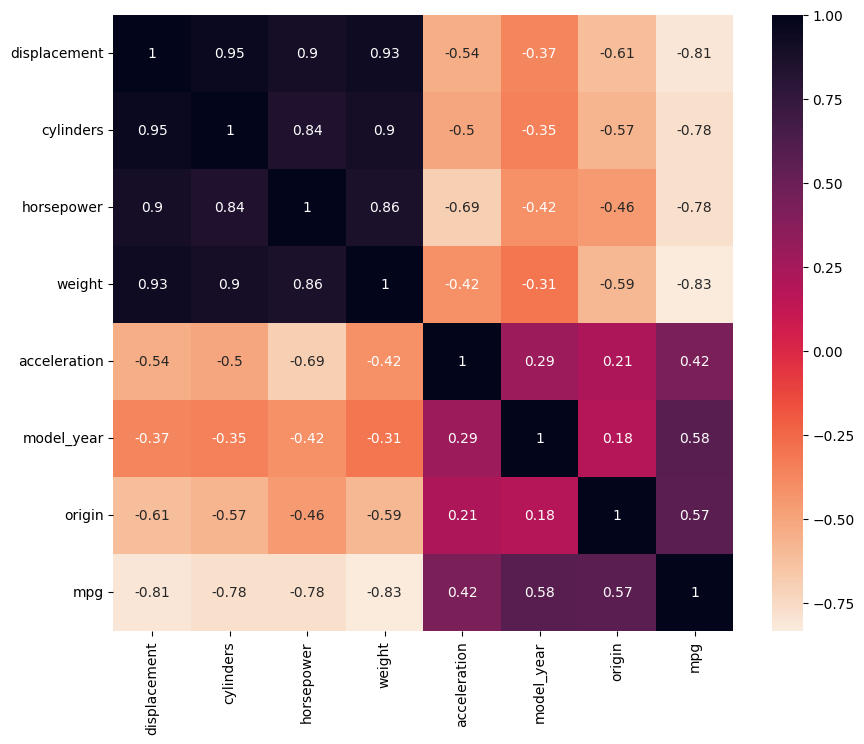

In [11]:
# Checking coorelation within the dataset
dataset_corr = dataset.corr()
plt.figure(figsize=(10,8))
sns.heatmap(dataset_corr, cmap='rocket_r',annot=True)
plt.show()

In [12]:
# Feature selection
threshold = 0.35
target_corr = abs(dataset_corr.iloc[:, -1])
features = target_corr[target_corr > threshold].index

# Display the relevant features
dataset = dataset[features]
print("Relevant Features:\n", features.values)

Relevant Features:
 ['displacement' 'cylinders' 'horsepower' 'weight' 'acceleration'
 'model_year' 'origin' 'mpg']


In [13]:
# Extract X and Y from dataset
X = dataset.iloc[:, :-1]
Y = dataset.iloc[:, -1]

# Split the dataset into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=42)

# Print the first few records
print(f'Feature Train Dataset:\n{X_train.head()}\nsize: {X_train.shape}\n')
print(f'Target Train Dataset:\n{Y_train.head()}\nsize: {Y_train.shape}\n')
print(f'Feature Test Dataset:\n{X_test.head()}\nsize: {X_test.shape}\n')
print(f'Target Test Dataset:\n{Y_test.head()}\nsize: {Y_test.shape}\n')

# Apply Scaler of the dataset
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Feature Train Dataset:
     displacement  cylinders  horsepower  weight  acceleration  model_year  \
260         225.0          6       110.0    3620          18.7          78   
184         140.0          4        92.0    2572          14.9          76   
174         171.0          6        97.0    2984          14.5          75   
64          318.0          8       150.0    4135          13.5          72   
344          86.0          4        64.0    1875          16.4          81   

     origin  
260       1  
184       1  
174       1  
64        1  
344       1  
size: (313, 7)

Target Train Dataset:
260    18.6
184    25.0
174    18.0
64     15.0
344    39.0
Name: mpg, dtype: float64
size: (313,)

Feature Test Dataset:
     displacement  cylinders  horsepower  weight  acceleration  model_year  \
79           96.0          4        69.0    2189          18.0          72   
276         121.0          4       115.0    2795          15.7          78   
248          91.0          4  

In [14]:
# Convert the data into tensor
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train = torch.tensor(Y_train.values, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_test = torch.tensor(Y_test.values, dtype=torch.float32).to(device)

# Print shapes of the tensors
print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Y_test shape: {Y_test.shape}')

X_train shape: torch.Size([313, 7])
Y_train shape: torch.Size([313])
X_test shape: torch.Size([79, 7])
Y_test shape: torch.Size([79])


### Model Creation and Training

In [15]:
class LinearRegression(nn.Module):
    """
    A Linear Regressor.
    """

    def __init__(self, in_features: int, out_features: int, learning_rate: float = 0.01, reg_param: float = 0.1, random_state: int = None):
        """
        Constructor for Linear Regression.

        in_features: int: The number of input features.
        out_features: int: The number of output features.
        random_state: int: The seed for the random number generator.
        reg_param: float: The regularization parameter.
        """
        
        super(LinearRegression, self).__init__()
        if random_state is not None:
            np.random.seed(random_state)
        self.W = torch.tensor(np.random.randn(out_features, in_features), dtype=torch.float32).to(device)
        self.b = torch.tensor(np.random.randn(1, out_features), dtype=torch.float32).to(device)
        self.lr = learning_rate
        self.reg_param = reg_param
        self.in_features = in_features
        self.out_features = out_features

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        X: torch.Tensor: The input tensor.
        """

        return torch.matmul(X, self.W.T) + self.b
    
    def fit(self, X: torch.Tensor, y: torch.Tensor, epochs: int = 100, print_cost: bool = False):
        """
        X: torch.Tensor: The input tensor.
        """

        X, y = X.reshape(-1, self.in_features).to(device), y.reshape(-1, self.out_features).to(device)
        m = X.shape[0]

        Cost = []
        for i in range(epochs):
            # Forward pass
            predictions = self.forward(X)
            cost = torch.mean((predictions - y) ** 2)/2 + self.reg_param * torch.norm(self.W)/m
            Cost.append(cost.item())

            # Backward pass
            dW = (torch.matmul((predictions - y).T, X) + self.reg_param * self.W)/m
            db = torch.mean(predictions - y, dim=0, keepdim=True)

            # Update the weights
            self.W = (self.W - self.lr * dW).to(device)
            self.b = (self.b - self.lr * db).to(device)

            # Print the cost
            if print_cost and (i+1) % 100 == 0:
                print(f'Cost at epoch {i+1}: {round(cost.item(), 3)}')
                print("\n------------------------------------------------------------\n")

        return Cost
    
    def predict(self, X: torch.Tensor) -> torch.Tensor:
        """
        X: torch.Tensor: The input tensor.
        """

        return self.forward(X)

    def save_model(self, path):
        """
        Save the model parameters.

        path: str: The path where the model parameters should be saved.
        """
        torch.save({
            'W': self.W,
            'b': self.b,
            'lr': self.lr,
            'reg_param': self.reg_param,
            'in_features': self.in_features,
            'out_features': self.out_features
        }, path)

    @staticmethod
    def load_model(path):
        """
        Load the model parameters.

        path: str: The path from where the model parameters should be loaded.
        """
        state_dict = torch.load(path, map_location=torch.device('cpu'))
        model = LinearRegression(in_features=state_dict['in_features'], out_features=state_dict['out_features'], learning_rate=state_dict['lr'], reg_param=state_dict['reg_param'])
        model.W = state_dict['W']
        model.b = state_dict['b']
        return model

In [16]:
# Define the model for Linear Regression
model = LinearRegression(in_features=X_train.shape[1], out_features=1, learning_rate=0.01, reg_param=0.1, random_state=42).to(device)

In [17]:
# Training the model
cost = model.fit(X_train, Y_train, epochs=1000, print_cost=True)

# Calculating the metrics
Y_pred = model.predict(X_train).detach()
print(f"Train MSE: {mean_squared_error(Y_train.cpu(), Y_pred.cpu())}")

Cost at epoch 100: 42.995

------------------------------------------------------------

Cost at epoch 200: 11.381

------------------------------------------------------------

Cost at epoch 300: 6.941

------------------------------------------------------------

Cost at epoch 400: 6.222

------------------------------------------------------------

Cost at epoch 500: 6.036

------------------------------------------------------------

Cost at epoch 600: 5.943

------------------------------------------------------------

Cost at epoch 700: 5.876

------------------------------------------------------------

Cost at epoch 800: 5.821

------------------------------------------------------------

Cost at epoch 900: 5.776

------------------------------------------------------------

Cost at epoch 1000: 5.739

------------------------------------------------------------

Train MSE: 11.47452163696289


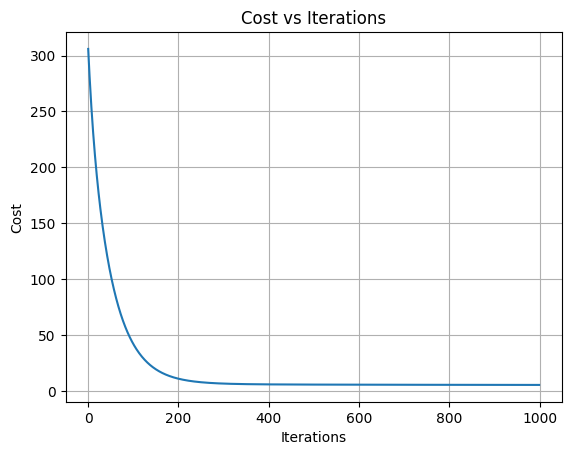

In [18]:
# Plot the cost vs iterations
plt.plot(np.arange(len(cost)), cost)
plt.title('Cost vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.grid()
plt.show()

### Testing and Plotting

In [19]:
# Predicting the values
Y_pred = model.predict(X_test).detach()

# Calculating the metrics
print(f'Test MSE: {mean_squared_error(Y_test.cpu(), Y_pred.cpu())}')

Test MSE: 11.743207931518555


In [20]:
# Train the model with different hyperparameters
Metrics = {}
Costs = {}
for lr in np.arange(0.001, 0.111, 0.01):
    print(f"Linear Regression with learning rate {round(lr, 3)}")

    # Defining the model for Linear Regression
    model = LinearRegression(in_features=X_train.shape[1], out_features=1, learning_rate=lr, reg_param=0.1, random_state=42).to(device)
    start = time()
    cost = model.fit(X_train, Y_train, epochs=100)
    end = time()
    train_time = end - start

    # Calculating the metrics
    Y_pred = model.predict(X_train).detach()
    train_mse = mean_squared_error(Y_train.cpu(), Y_pred.cpu())
    start = time()
    Y_pred = model.predict(X_test).detach()
    end = time()
    predict_time = end - start
    test_mse = mean_squared_error(Y_test.cpu(), Y_pred.cpu())

    # Storing the metrics
    Metrics[lr] = {"Train MSE": train_mse, "Test MSE": test_mse, "Train Time": train_time, "Predict Time": predict_time}
    Costs[lr] = cost
    print(f"Train MSE: {train_mse:.3f}")
    print(f"Test MSE: {test_mse:.3f}")

    print("\n------------------------------------------------------------\n")

Metrics = pd.DataFrame(Metrics).T
Costs = pd.DataFrame(Costs)

Linear Regression with learning rate 0.001
Train MSE: 473.698
Test MSE: 427.339

------------------------------------------------------------

Linear Regression with learning rate 0.011
Train MSE: 71.529
Test MSE: 62.047

------------------------------------------------------------

Linear Regression with learning rate 0.021
Train MSE: 20.591
Test MSE: 18.256

------------------------------------------------------------

Linear Regression with learning rate 0.031
Train MSE: 13.511
Test MSE: 12.990

------------------------------------------------------------

Linear Regression with learning rate 0.041
Train MSE: 12.358
Test MSE: 12.367

------------------------------------------------------------

Linear Regression with learning rate 0.051
Train MSE: 12.039
Test MSE: 12.218

------------------------------------------------------------

Linear Regression with learning rate 0.061
Train MSE: 11.864
Test MSE: 12.102

------------------------------------------------------------

Linear Regr

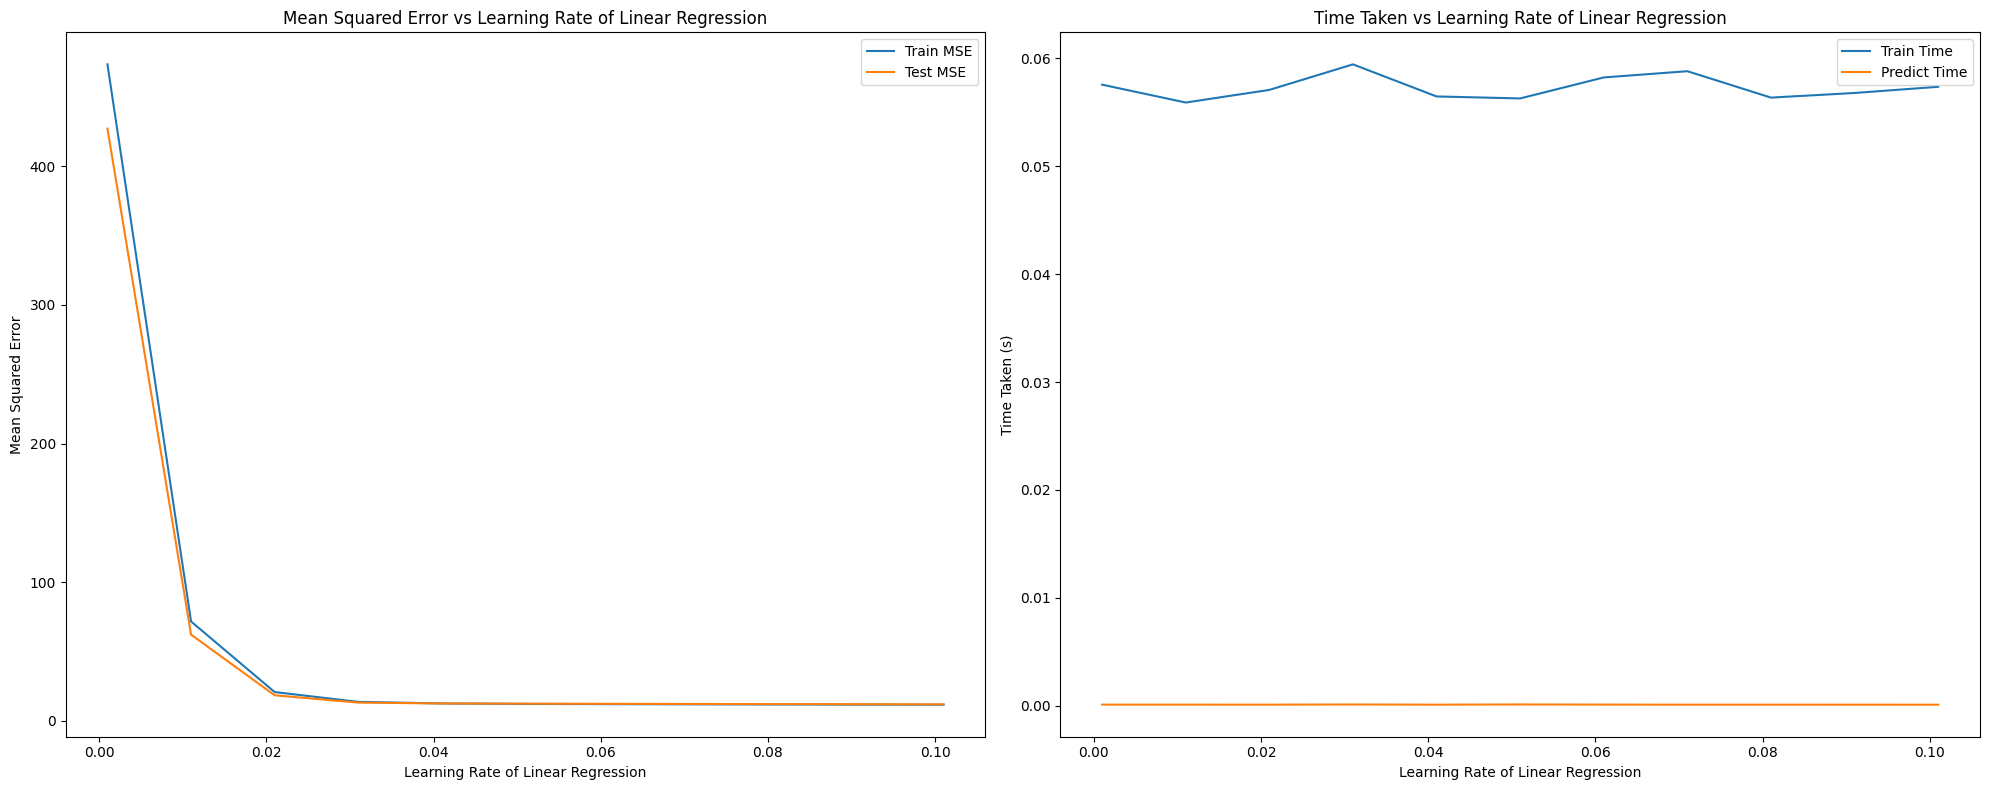

In [21]:
# Plotting the metrics
plot_metrics(Metrics, 'Learning Rate')

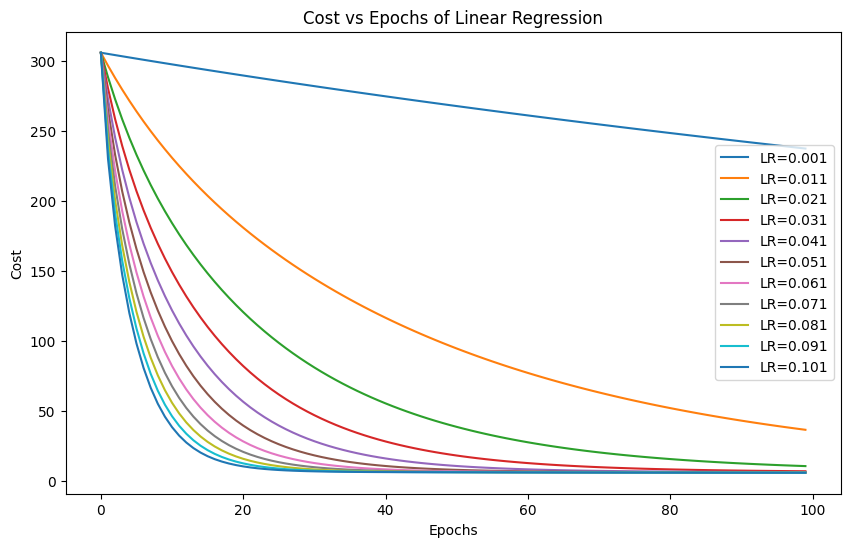

In [22]:
# Plotting the cost
plt.figure(figsize=(10, 6))
for lr in Costs.columns:
    plt.plot(Costs[lr], label=f'LR={round(lr, 3)}')

plt.title('Cost vs Epochs of Linear Regression')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()
plt.show()

### Generating and Saving Models

In [23]:
# Specify the directory you want to save in
directory = "Models"
os.makedirs(directory, exist_ok=True)

# Train the model with different hyperparameters
for epochs in np.arange(10, 110, 10):
    for lr in [0.001, 0.01, 0.1]:
        print(f"Linear Regression with {epochs} epochs, and {lr} learning rate")

        # Defining the model for Linear Regression
        model = LinearRegression(in_features=X_train.shape[1], out_features=1, learning_rate=lr, reg_param=0.1, random_state=42).to(device)
        model.fit(X_train, Y_train, epochs=epochs)

        # Saving the model
        filepath = os.path.join(directory, f"Linear_{lr}_{epochs}.pth")
        model.save_model(filepath)
        print("\n------------------------------------------------------------\n")

# Saving the Standard Scaler
filepath = os.path.join(directory, "Linear_StandardScaler.pkl")
with open(filepath, "wb") as file:
    pickle.dump(scaler, file)

Linear Regression with 10 epochs, and 0.001 learning rate

------------------------------------------------------------

Linear Regression with 10 epochs, and 0.01 learning rate

------------------------------------------------------------

Linear Regression with 10 epochs, and 0.1 learning rate

------------------------------------------------------------

Linear Regression with 20 epochs, and 0.001 learning rate

------------------------------------------------------------

Linear Regression with 20 epochs, and 0.01 learning rate

------------------------------------------------------------

Linear Regression with 20 epochs, and 0.1 learning rate

------------------------------------------------------------

Linear Regression with 30 epochs, and 0.001 learning rate

------------------------------------------------------------

Linear Regression with 30 epochs, and 0.01 learning rate

------------------------------------------------------------

Linear Regression with 30 epochs, and 0

## Logistic Regression Model

### Imports and Utils

In [1]:
"""
Importing the necessary libraries
"""
import os
from time import time
import pickle
from typing import Union
import zipfile
import requests
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
"""
Metric functions for the Model
"""

def accuracy(y_true: pd.Series, y_pred: pd.Series) -> float:
    """
    y_true: pd.Series: True labels
    y_pred: pd.Series: Predicted labels

    Returns: float: Accuracy
    """

    assert y_pred.size == y_true.size
    accuracy = np.isclose(y_true.values, y_pred.values, atol=0.01).mean()
    return accuracy

def Precision(y_true: pd.Series, y_pred: pd.Series, cls: Union[int, str]) -> float:
    """
    y_true: pd.Series: True labels
    y_pred: pd.Series: Predicted labels
    cls: Union[int, str]: Class to calculate precision for

    Returns: float: Precision
    """

    assert y_pred.shape == y_true.shape
    tp = ((np.isclose(y_pred, cls, atol=0.01)) & (np.isclose(y_true, cls, atol=0.01))).sum()
    fp = ((np.isclose(y_pred, cls, atol=0.01)) & ~(np.isclose(y_true, cls, atol=0.01))).sum()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    return precision

def Recall(y_true: pd.Series, y_pred: pd.Series, cls: Union[int, str]) -> float:
    """
    y_true: pd.Series: True labels
    y_pred: pd.Series: Predicted labels
    cls: Union[int, str]: Class to calculate recall for

    Returns: float: Recall
    """

    assert y_pred.shape == y_true.shape
    tp = ((np.isclose(y_pred, cls, atol=0.01)) & (np.isclose(y_true, cls, atol=0.01))).sum()
    fn = (~(np.isclose(y_pred, cls, atol=0.01)) & (np.isclose(y_true, cls, atol=0.01))).sum()
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    return recall

def F1_Score(y_true: pd.Series, y_pred: pd.Series, cls: Union[int, str]) -> float:
    """
    y_true: pd.Series: True labels
    y_pred: pd.Series: Predicted labels
    cls: Union[int, str]: Class to calculate F1 score for

    Returns: float: F1 score
    """

    assert y_pred.shape == y_true.shape
    prec = Precision(y_true, y_pred, cls)
    rec = Recall(y_true, y_pred, cls)
    f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
    return f1

def MCC(y_true: pd.Series, y_pred: pd.Series, cls: Union[int, str]) -> float:
    """
    y_true: pd.Series: True labels
    y_pred: pd.Series: Predicted labels
    cls: Union[int, str]: Class to calculate Matthews Correlation Coefficient for

    Returns: float: Matthews Correlation Coefficient
    """

    assert y_pred.shape == y_true.shape
    tp = ((np.isclose(y_pred, cls, atol=0.01)) & (np.isclose(y_true, cls, atol=0.01))).sum()
    tn = (~(np.isclose(y_pred, cls, atol=0.01)) & ~(np.isclose(y_true, cls, atol=0.01))).sum()
    fp = ((np.isclose(y_pred, cls, atol=0.01)) & ~(np.isclose(y_true, cls, atol=0.01))).sum()
    fn = (~(np.isclose(y_pred, cls, atol=0.01)) & (np.isclose(y_true, cls, atol=0.01))).sum()

    mcc_n = (tp * tn) - (fp * fn)
    mcc_d = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    mcc = mcc_n / mcc_d if mcc_d > 0 else 0
    return mcc

In [ ]:
# Plotting the metrics
def plot_metrics(Metrics: pd.DataFrame, title: str):
    """
    Metrics: pd.DataFrame: Metrics computed of the model.
    title: string: X-axis of the plots.
    """
        
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    Metrics.iloc[:, :2].plot(ax=axs[0, 0])
    axs[0, 0].set_xlabel(f'{title} of Logistic Regression')
    axs[0, 0].set_ylabel('Mean Squared Error')
    axs[0, 0].set_title(f'Mean Squared Error vs {title} of Logistic Regression')

    Metrics.iloc[:, 2:4].plot(ax=axs[0, 1])
    axs[0, 1].set_xlabel(f'{title} of Logistic Regression')
    axs[0, 1].set_ylabel('Time Taken (s)')
    axs[0, 1].set_title(f'Time Taken vs {title} of Logistic Regression')

    Metrics.iloc[:, 4:6].plot(ax=axs[1, 0])
    axs[1, 0].set_xlabel(f'{title} of Logistic Regression')
    axs[1, 0].set_ylabel('Accuracy')
    axs[1, 0].set_title(f'Accuracy vs {title} of Logistic Regression')
        
    plt.tight_layout()
    plt.show()

### Dataset Loading and Preprocessing

In [ ]:
# '''
# Dataset download links Cats vs Dogs
local_zip = "cats-and-dogs.zip"
url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"

# Loading the Data or Downloading the Data.
response = requests.get(url)
with open(local_zip, 'wb') as file:
    file.write(response.content)

# Processing the zip file of the Data
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("./Datasets/")
zip_ref.close()
# '''

In [3]:
# Define the transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.permute(1, 2, 0) if x.shape[0] == 3 else torch.cat([x, x, x], 0).permute(1, 2, 0))
])

# Apply the transformation to the images
folder = './Datasets/PetImages'
n_data = 1000
dataset = []
labels = []
for class_name in os.listdir(folder):
    class_folder = os.path.join(folder, class_name)
    count = 0
    for filename in os.listdir(class_folder):
        if count >= n_data:
            break
        try:
            img = Image.open(os.path.join(class_folder, filename)).convert('RGB')
            img = transform(img).to(device)
            dataset.append(img)
            labels.append(0 if class_name == 'Cat' else 1)
            count += 1
        except Exception as e:
            print(f"Skipping file {filename} due to error: {e}")

# Convert the list of labels to a tensor and move it to the GPU
dataset = torch.stack(dataset).to(device)
labels = torch.tensor(labels).to(device)

# Print the shape of the dataset and label tensors
print(f"Shape of the dataset: {dataset.shape}")
print(f"Shape of the labels: {labels.shape}")

Shape of the dataset: torch.Size([2000, 256, 256, 3])
Shape of the labels: torch.Size([2000])


In [4]:
# Reshape the dataset
dataset = dataset.reshape(-1, 256*256*3)

# Print the shape of the dataset and label tensors
print(f"Shape of the dataset: {dataset.shape}")
print(f"Shape of the labels: {labels.shape}")

Shape of the dataset: torch.Size([2000, 196608])
Shape of the labels: torch.Size([2000])


### Model Creation and Training

In [ ]:
class LogisticRegression(nn.Module):
    """
    A Logistic Regressor.
    """

    def __init__(self, in_features: int, out_features: int, learning_rate: float = 0.01, random_state: int = None):
        """
        Constructor for Logistic Regression.

        in_features: int: The number of input features.
        out_features: int: The number of output features.
        random_state: int: The seed for the random number generator.
        """
        
        super(LogisticRegression, self).__init__()
        if random_state is not None:
            np.random.seed(random_state)
        self.W = torch.tensor(np.random.randn(out_features, in_features), dtype=torch.float32).to(device)
        self.b = torch.tensor(np.random.randn(1, out_features), dtype=torch.float32).to(device)
        self.lr = learning_rate
        self.in_features = in_features
        self.out_features = out_features

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        X: torch.Tensor: The input tensor.
        """

        return torch.sigmoid(torch.matmul(X, self.W.T) + self.b)
    
    def fit(self, X: torch.Tensor, y: torch.Tensor, epochs: int = 100, print_cost: bool = False):
        """
        X: torch.Tensor: The input tensor.
        """

        X, y = X.reshape(-1, self.in_features).to(device), y.reshape(-1, self.out_features).to(device)
        m = X.shape[0]

        Cost = []
        for i in range(epochs):
            # Forward pass
            predictions = self.forward(X)
            cost = F.binary_cross_entropy(predictions, y)
            Cost.append(cost.item())

            # Backward pass
            dW = torch.matmul((predictions - y).T, X)/m
            db = torch.mean(predictions - y, dim=0, keepdim=True)

            # Update the weights
            self.W = (self.W - self.lr * dW).to(device)
            self.b = (self.b - self.lr * db).to(device)

            # Print the cost
            if print_cost and (i+1) % 100 == 0:
                print(f'Cost at epoch {i+1}: {round(cost.item(), 3)}')
                print("\n------------------------------------------------------------\n")

        return Cost
    
    def predict(self, X: torch.Tensor) -> torch.Tensor:
        """
        X: torch.Tensor: The input tensor.
        """

        return self.forward(X)

    def save_model(self, path):
        """
        Save the model parameters.

        path: str: The path where the model parameters should be saved.
        """
        torch.save({
            'W': self.W,
            'b': self.b,
            'lr': self.lr,
            'in_features': self.in_features,
            'out_features': self.out_features
        }, path)

    @staticmethod
    def load_model(path):
        """
        Load the model parameters.

        path: str: The path from where the model parameters should be loaded.
        """
        state_dict = torch.load(path, map_location=torch.device('cpu'))
        model = LogisticRegression(in_features=state_dict['in_features'], out_features=state_dict['out_features'], learning_rate=state_dict['lr'])
        model.W = state_dict['W']
        model.b = state_dict['b']
        return model

In [ ]:
# Define the model for Logistic Regression
model = LogisticRegression(in_features=X_train.shape[1], out_features=1, learning_rate=0.01, random_state=42).to(device)

In [ ]:
# Training the model
cost = model.fit(X_train, Y_train, epochs=1000, print_cost=True)

# Calculating the metrics
Y_pred = model.predict(X_train).detach()
print(f"Train MSE: {mean_squared_error(Y_train.cpu(), Y_pred.cpu())}")

# Convert tensors to pandas.Series
Y_pred = Y_pred > 0.5
Y_train_series = pd.Series(Y_train.cpu().numpy().flatten())
Y_pred = pd.Series(Y_pred.cpu().numpy().flatten())
print(f"Train Accuracy: {accuracy(Y_train, Y_pred)}")

### Testing and Plotting

In [ ]:
# Predicting the values
Y_pred = model.predict(X_test).detach()

# Calculating the metrics
print(f'Test MSE: {mean_squared_error(Y_test.cpu(), Y_pred.cpu())}')

# Convert tensors to pandas.Series
Y_pred = Y_pred > 0.5
Y_test_series = pd.Series(Y_test.cpu().numpy().flatten())
Y_pred = pd.Series(Y_pred.cpu().numpy().flatten())
print(f"Test Accuracy: {accuracy(Y_test, Y_pred)}")

In [ ]:
# Train the model with different hyperparameters
Metrics = {}
Costs = {}
for lr in np.arange(0.001, 0.111, 0.01):
    print(f"Linear Regression with learning rate {round(lr, 3)}")

    # Defining the model for Logistic Regression
    model = LogisticRegression(in_features=X_train.shape[1], out_features=1, learning_rate=lr, random_state=42).to(device)
    start = time()
    cost = model.fit(X_train, Y_train, epochs=100)
    end = time()
    train_time = end - start

    # Calculating the metrics
    Y_pred = model.predict(X_train).detach()
    train_mse = mean_squared_error(Y_train.cpu(), Y_pred.cpu())
    Y_pred = Y_pred > 0.5
    Y_pred = pd.Series(Y_pred.cpu().numpy().flatten())
    train_accuracy = accuracy(Y_train_series, Y_pred)
    start = time()
    Y_pred = model.predict(X_test).detach()
    end = time()
    predict_time = end - start
    test_mse = mean_squared_error(Y_test.cpu(), Y_pred.cpu())
    Y_pred = Y_pred > 0.5
    Y_pred = pd.Series(Y_pred.cpu().numpy().flatten())
    test_accuracy = accuracy(Y_test_series, Y_pred)

    # Storing the metrics
    Metrics[lr] = {"Train MSE": train_mse, "Test MSE": test_mse, "Train Time": train_time, "Predict Time": predict_time, "Train Accuracy": train_accuracy, "Test Accuracy": test_accuracy}
    Costs[lr] = cost
    print(f"Train MSE: {train_mse:.3f}")
    print(f"Test MSE: {test_mse:.3f}")
    print(f"Train Accuracy: {train_accuracy:.3f}")
    print(f"Test Accuracy: {test_accuracy:.3f}")

    print("\n------------------------------------------------------------\n")

Metrics = pd.DataFrame(Metrics).T
Costs = pd.DataFrame(Costs)

In [ ]:
# Plotting the metrics
plot_metrics(Metrics, 'Learning Rate')

In [ ]:
# Plotting the cost
plt.figure(figsize=(10, 6))
for lr in Costs.columns:
    plt.plot(Costs[lr], label=f'LR={round(lr, 3)}')

plt.title('Cost vs Epochs of Logistic Regression')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()
plt.show()

### Generating and Saving Models

In [ ]:
# Specify the directory you want to save in
directory = "Models"
os.makedirs(directory, exist_ok=True)

# Train the model with different hyperparameters
for epochs in np.arange(10, 110, 10):
    for lr in [0.001, 0.01, 0.1]:
        print(f"Logistic Regression with {epochs} epochs, and {lr} learning rate")

        # Defining the model for Linear Regression
        model = LogisticRegression(in_features=X_train.shape[1], out_features=1, learning_rate=lr, random_state=42).to(device)
        model.fit(X_train, Y_train, epochs=epochs)

        # Saving the model
        filepath = os.path.join(directory, f"Logistic_{lr}_{epochs}.pth")
        model.save_model(filepath)
        print("\n------------------------------------------------------------\n")

# Saving the Standard Scaler
filepath = os.path.join(directory, "Logistic_StandardScaler.pkl")
with open(filepath, "wb") as file:
    pickle.dump(scaler, file)